2020.06.03 SR
Validating the SNANA hostgal spectroscopy simulations.   

Goal: compare some SNANA-simulated host galaxy spectra against real spectra. 

Compare the simulated spectra against the EAZY template and against actual observed DEIMOS spectra. 

In [32]:
%matplotlib inline

In [2]:
from matplotlib import pyplot as plt
from astropy.table import Table, Column
from astropy.io import ascii
import numpy as np
from astropy.io import fits
import os
import glob
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.cosmology import FlatLambdaCDM 
fLCDM = FlatLambdaCDM(H0=70, Om0=0.3)

In [4]:
from plot_snana import plot_snana
from salt3.util import readutils as salt3readutils
from salt3.util import snana
#import snhostspec_simcheck

In [8]:
# Master directory where the hostlib files and SNANA sim products are located
datadir = os.path.expanduser("~/Dropbox/src/wfirst/DATA/")

In [9]:
# Sub-directory with the data of interest today
datasubdir = "2020.06.02.debugging_ringing_spectra"

### 3. Plot the simulated spectra and the real spectra

In [6]:
_SHOW_EAZY = False

In [7]:
if _SHOW_EAZY:
    # Read in the eazypy template data
    eazy_templates_filename = os.path.join(datadir,"eazy_13_spectral_templates.dat")
    eazytemplatedata = snhostspec_simcheck.load_eazypy_templates(eazy_templates_filename)

In [49]:
# Make a list of the SNANA-simulated spectra
snana_specsim_dir = os.path.join(datadir,datasubdir)
snana_specsim_datfile_list = sorted(glob.glob(os.path.join(snana_specsim_dir,"*.DAT")))

In [50]:
snana_specsim_datfile_list

['/Users/rodney/Dropbox/src/wfirst/DATA/2020.06.02.debugging_ringing_spectra/WFIRST_DEMOS_T1_RAH_SN000006.DAT',
 '/Users/rodney/Dropbox/src/wfirst/DATA/2020.06.02.debugging_ringing_spectra/WFIRST_DEMOS_T3_RAH_SN000006.DAT']

In [51]:
datfile = snana_specsim_datfile_list[0]
sn = snana.SuperNova(datfile=datfile)

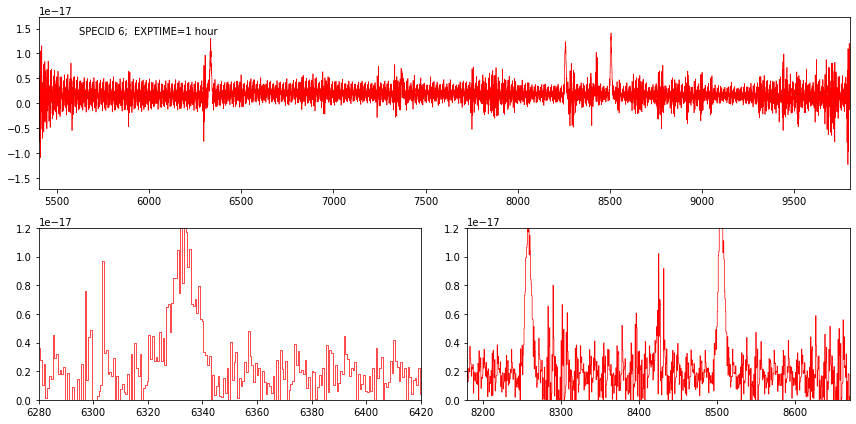

In [55]:
fig = plt.figure(figsize=[12,6])
ax0 = fig.add_subplot(2,1,1)
ax1 = fig.add_subplot(2,2,3)
ax2 = fig.add_subplot(2,2,4)

ax0.plot(sn.SPECTRA[0]['LAMMIN'], sn.SPECTRA[0]['FLAM'], color='r', ls='-', lw=0.7, drawstyle='steps-mid')
ax1.plot(sn.SPECTRA[0]['LAMMIN'], sn.SPECTRA[0]['FLAM'], color='r', ls='-', lw=0.7, drawstyle='steps-mid')

ax2.plot(sn.SPECTRA[0]['LAMMIN'], sn.SPECTRA[0]['FLAM'], color='r', ls='-', lw=0.7, drawstyle='steps-mid')

ax0.set_xlim(5400,9800)
ax1.set_ylim(0,1.3e-17)

ax1.set_xlim(6280,6420)
ax1.set_ylim(0,1.2e-17)

ax2.set_xlim(8180,8670)
ax2.set_ylim(0,1.2e-17)

ax0.text(0.05, 0.95, "SPECID 6;  EXPTIME=1 hour", ha='left', va='top', transform=ax0.transAxes)
plt.tight_layout()
plt.savefig( datfile.replace(".DAT", ".png"))

In [17]:
# Construct a catalog of SNANA-simulation hostgal info (galid,ra,dec,z) by 
# reading all the individual .dat files 
snlist = []
for datfile in snana_specsim_datfile_list:
    sn = snana.SuperNova(datfile=datfile)
    snlist.append(sn)
    
columnlist= [
    Column(data=np.arange(1,len(snlist)+1), name='IDX_SIM'),
    Column(data=[sn.HOSTGAL_OBJID for sn in snlist], name='galid'),
    Column(data=[float(sn.HOSTGAL_RA.split()[0]) for sn in snlist], name='ra'),
    Column(data=[float(sn.HOSTGAL_DEC.split()[0]) for sn in snlist], name='dec'),
    Column(data=[sn.SIM_REDSHIFT_CMB for sn in snlist], name='zsim'),
    Column(data=[sn.SIM_REDSHIFT_HOST for sn in snlist], name='zobs'),
    Column(data=[sn.datfile for sn in snlist], name='datfile'),
]
hostsimtable = Table(data=columnlist)

In [18]:
sn = snlist[0]
#sn.__dict__.keys()

In [19]:
hostsimtable[np.where(hostsimtable['galid']==216137)]

IDX_SIM,galid,ra,dec,zsim,zobs,datfile
int64,int64,float64,float64,float64,float64,str107


In [20]:
def plotbrightlines(z, ax=None):
    if ax is None:
        ax = plt.gca()
    ax.axvline(3728*(1+z), ls='--', lw=0.5, color='darkorchid', label='OII')
    ax.axvline(4860*(1+z), ls='--', lw=0.5, color='b', label='Hb')
    ax.axvline(5007*(1+z), ls='--', lw=0.5, color='g', label='OII')
    ax.axvline(6563*(1+z), ls='--', lw=0.5, color='r', label='Ha')


# This function requires that the master hostlib catalog (mastercat) has been read in and 
# the table of simulated host spectra (hostsimtable) has been created 
def plot_snanasimspec_and_eazy_sed(isim):
    """Make a plot of the ith simulated host spectrum, showing 
    all 3 simulated SNANA spectra (exposure times of 1hr, 10hrs, 100hrs)
    and the EAZY SED that (allegedly) was used to generate them"""
    snsim = snlist[isim]
    galidsim = hostsimtable[isim]['galid']
    zsim = hostsimtable[isim]['zsim']
    zobs = hostsimtable[isim]['zobs']
    rasim = hostsimtable[isim]['ra']
    decsim = hostsimtable[isim]['dec']

    ithisgal_mastercat = np.where(mastercat['GALID']==galidsim)[0][0]
    mJ = mastercat[ithisgal_mastercat]['wfirst_j129_obs']
    galidhostlib = mastercat[ithisgal_mastercat]['GALID']
    rahostlib = mastercat[ithisgal_mastercat]['RA_GAL']
    dechostlib = mastercat[ithisgal_mastercat]['DEC_GAL']
    zhostlib = mastercat[ithisgal_mastercat]['ZTRUE']
    
    # plot the EAZY simulated spectrum
    eazycoeffs = np.array([mastercat[col][ithisgal_mastercat]
                           for col in mastercat.colnames
                           if col.startswith('coeff_specbasis')])
    wez, mez = snhostspec_simcheck.simulate_eazy_sed_from_coeffs(
        eazycoeffs, eazytemplatedata, zsim,
        returnwaveunit='A', returnfluxunit='flambda',
        savetofile=None, overwrite=False)
    
    # PLOT THE SNANA SIMULATED SPECTRA AND THE EAZY-PY MODEL
    fig = plt.figure(figsize=[8.5,11])
    ax1 = fig.add_subplot(511)
    ax2 = fig.add_subplot(512, sharex=ax1)
    ax3 = fig.add_subplot(513, sharex=ax1)
    ax4 = fig.add_subplot(514, sharex=ax1)
    ax5 = fig.add_subplot(515, sharex=ax1)

    axez=ax4

    for ispec,ax in zip([0,1,2],[ax1,ax2,ax3]):
        spec = snsim.SPECTRA[ispec]
        ax.plot(spec['LAMCEN'], spec['FLAM']*1e17)
        ax.set_ylim(-0.3,1.6)
        plotbrightlines(zsim, ax)

   
    axez.plot(wez, mez, label='EAZY SED fit', color='k', zorder=10)

    axez.set_xlim(5200,10200)
    plotbrightlines(zsim, axez)
    
    axez.text(0.95,0.95, '{:d} z_sim={:.2f} ra,dec={:.4f},{:.4f}'.format(
        galidsim, zsim, rasim, decsim),
             transform=ax1.transAxes, ha='right', va='top')

    axez.text(0.95,0.95, '{:d} z_sim={:.2f} mJ={:.1f}, ra,dec={:.4f},{:.4f}'.format(
        galidhostlib, zhostlib, mJ, rahostlib, dechostlib),
             transform=ax5.transAxes, ha='right', va='top')
    
    ax1.text(0.05,1.02, os.path.basename(snsim.datfile), ha='left', va='bottom', transform=ax1.transAxes)

    
    # Plot the observed deimos spectrum
    medsmooth = lambda f,N : np.array( [ np.median( f[max(0,i-N):min(len(f),max(0,i-N)+2*N)]) for i in range(len(f)) ] )    
    cosmos_deimos_specfile=os.path.join(
        datadir,"cosmos_example_spectra/cosmos_example_spec1d_{:6d}.fits".format(galidsim))
    if os.path.exists(cosmos_deimos_specfile):
        deimosdat = Table.read(cosmos_deimos_specfile)
        wave = np.array(deimosdat['LAMBDA'][0])
        flux = np.array(deimosdat['FLUX'][0])
        ax5.plot(wave, flux, color='0.8')
        ax5.plot(wave, medsmooth(flux,20), color='darkorange')
        plotbrightlines(zobs, ax5)
        ax5.text(0.05,0.95, "Actual DEIMOS spectrum:  z_obs={:.3f}".format(zobs), transform=ax5.transAxes, ha='left', va='top')
                
    plt.tight_layout()

/usr/local/anaconda3/envs/astroconda/lib/python3.7/site-packages/ipykernel_launcher.py:85: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations


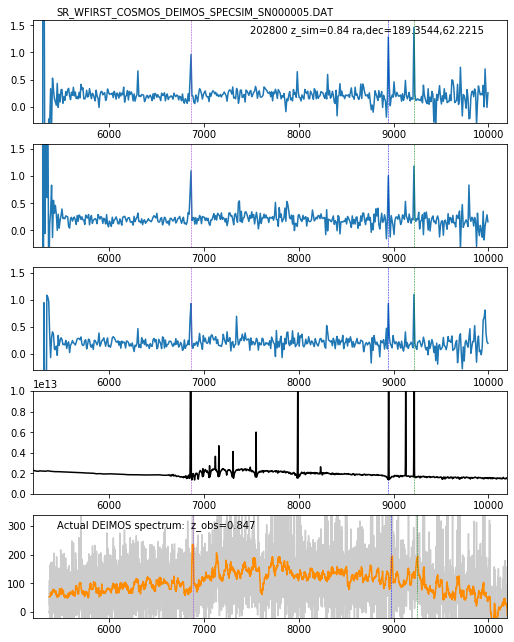

In [118]:
#for isim in [2]:#,14,19]:
isim = 4
plot_snanasimspec_and_eazy_sed(isim)
fig = plt.gcf()
axlist = fig.axes
axez = axlist[3]
axez.set_ylim(0,1e13)
axd = axlist[4]
axd.set_ylim(-20,340)
plt.savefig("/Users/rodney/Desktop/sim{:03d}.png".format(isim))

In [ ]:
# FIND AN ACTUAL DEIMOS SPECTRUM 
ihostgal_mastercat = [np.where(mastercat['GALID']==hostsimtable[isim]['galid'])[0][0]
                      for isim in range(len(snlist))]

icosmos = np.where(np.abs(mastercat['GALID'][ihostgal_mastercat]-250000)<50000)[0]
ra_cosmos_sim = mastercat['RA_GAL'][ihostgal_mastercat][icosmos]
dec_cosmos_sim = mastercat['DEC_GAL'][ihostgal_mastercat][icosmos]
galid_cosmos_sim = mastercat['GALID'][ihostgal_mastercat][icosmos]

In [ ]:

# find SNANA-Simulated galaxies that are also in the COSMOS real spectra catalog

cosmos_sim_coords = SkyCoord(ra=ra_cosmos_sim*u.degree, 
                          dec=dec_cosmos_sim*u.degree)
cosmos_real_coords = SkyCoord(ra=cosmosrealspecdata['ra']*u.degree, 
                            dec=cosmosrealspecdata['dec']*u.degree)

max_sep = 2.0 * u.arcsec

idx_sim, d2d, d3d = cosmos_sim_coords.match_to_catalog_sky(cosmos_real_coords)
#idx_real, d2d, d3d = cosmos_real_coords.match_to_catalog_sky(cosmos_sim_coords)

sep_constraint = d2d < max_sep
match_galids = galid_cosmos_sim[sep_constraint]
#cosmos = catalog[idx[sep_constraint]]

In [ ]:
idx_sim, sep_constraint, match_galids
len(cosmos_sim_coords)

In [ ]:
cosmosrealspecdata['ascii1d'][idx_real]
#plot_snanasimspec_and_eazy_sed(0)

In [ ]:
idx, d2d, d2d.to(u.arcsec), d3d

In [ ]:
plt.plot(cosmosrealspecdata['ra'], cosmosrealspecdata['dec'], marker='o', color='r', ls=' ', alpha=0.1)
plt.plot(ra_cosmos_sim, dec_cosmos_sim, marker='s', color='b', ls=' ', alpha=0.5)


# FOLLOWING IS DEFUNCT CODE, CHECKING RA,DEc VALs

In [ ]:
ralist = []
declist = []
for sn in snlist:
    ra = float(sn.HOSTGAL_RA.split()[0])
    dec = float(sn.HOSTGAL_DEC.split()[0])
    ralist.append(ra)
    declist.append(dec)
ax = plt.gca()
ax.plot(ralist, declist, marker='o', ls=' ')